In [1]:
import pandas as pd
import numpy as np

from prophet            import Prophet
from prophet.plot       import add_changepoints_to_plot
from sktime.datasets    import load_airline
from matplotlib         import pyplot as plt

In [2]:
df = pd.DataFrame(load_airline())
df.columns = ['y']
df["ds"]= df.index.to_timestamp()
df = df.reset_index(drop=True)

17:46:42 - cmdstanpy - INFO - Chain [1] start processing
17:46:42 - cmdstanpy - INFO - Chain [1] done processing


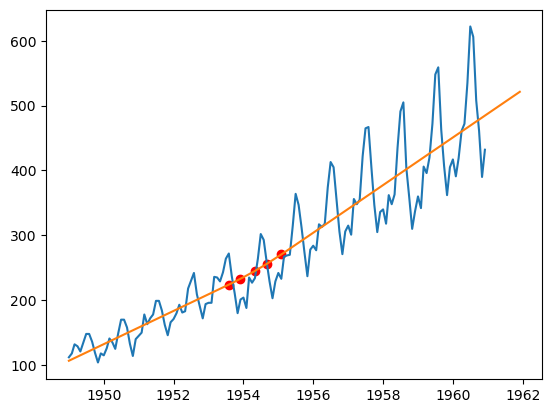

In [3]:
m = Prophet(
            n_changepoints=25,
            changepoint_prior_scale = 0.05,
            changepoint_range=0.8,
            growth='linear'
            )
m.fit(df)

future = m.make_future_dataframe(periods=365)
df_trend = m.setup_dataframe(future.copy())
df_trend["trend"] = m.predict_trend(df_trend)

plt.plot(df["ds"],df["y"])
plt.plot(df_trend["ds"],df_trend["trend"])
threshold=0.01

signif_changepoints = m.changepoints[np.abs(np.nanmean(m.params['delta'], axis=0)) >= threshold]
a = [i for i,value in enumerate(df_trend["ds"]) if value in signif_changepoints.values]
plt.scatter(signif_changepoints,df_trend["trend"].iloc[a],c='r')

plt.show()

In [4]:
m.params['delta']

array([[-3.77721e-09,  1.10637e-08,  6.48932e-09,  3.68139e-11,
         4.13612e-09,  4.31249e-10,  1.37733e-09,  3.14097e-09,
        -2.02835e-09,  2.41009e-10,  4.78675e-09,  2.79697e-02,
         4.24256e-02,  5.49375e-02,  5.16221e-02,  3.11753e-02,
         5.01564e-03, -9.91419e-10,  6.78758e-09, -1.63825e-10,
         4.95407e-09, -5.48023e-09,  4.94299e-09,  4.50761e-07,
         1.51765e-07]])

### Checking with the Mittelfrist Data

In [29]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.compose             import TransformedTargetForecaster,ForecastingPipeline
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings

In [30]:
pdf = pd.read_csv("../../mittelfristlastprognose/data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

# y_train, y_test = temporal_train_test_split(pdf)

# idx = pd.period_range(start=y_train.index[0], end= y_train.index[-1], freq="M")
# y_train = pd.Series(y_train.y.values, index=idx)

In [6]:
pdf["ds"] = pdf.index
pdf["y"] = pdf.y

In [28]:
warnings.filterwarnings("ignore")

detrender = TrendForecaster(Ridge())
detrender.fit(pdf["y"])
y_= detrender.predict(fh=pdf["ds"].index)

18:51:01 - cmdstanpy - INFO - Chain [1] start processing
18:51:01 - cmdstanpy - INFO - Chain [1] done processing


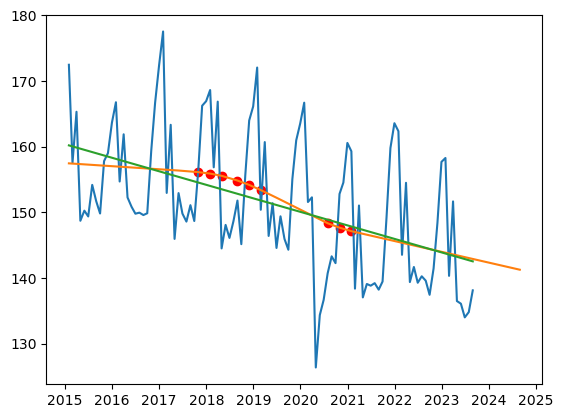

In [27]:
m = Prophet(
            n_changepoints=25,
            changepoint_prior_scale = 0.05, #0.05
            changepoint_range=0.8,
            growth='linear'
            )
m.fit(pdf)

future = m.make_future_dataframe(periods=365)
df_trend = m.setup_dataframe(future.copy())
df_trend["trend"] = m.predict_trend(df_trend)


plt.plot(pdf["ds"],pdf["y"])
plt.plot(df_trend["ds"],df_trend["trend"])
threshold=0.01

signif_changepoints = m.changepoints[np.abs(np.nanmean(m.params['delta'], axis=0)) >= threshold]
a = [i for i,value in enumerate(df_trend["ds"]) if value in signif_changepoints.values]
plt.scatter(signif_changepoints,df_trend["trend"].iloc[a],c='r')
plt.plot(pdf["ds"],y_)
plt.show()